This notebook explores how to extract features from oriented 3D brains and tumor masks.
We are using [this radiomic feature library](https://pyradiomics.readthedocs.io/en/latest/index.html).

In [1]:
import glob
import os
import random
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import cv2
import scipy.ndimage as ndimage
import math
from tqdm.auto import tqdm
import SimpleITK as sitk
import radiomics

In [2]:
df = pd.read_csv('../input/train_labels_folds-v1.csv')
df.head()

,BraTS21ID,MGMT_value,fold
0,0,1,2
1,2,1,2
2,3,0,1
3,5,1,2
4,6,1,0


In [3]:
REG_DIR = '../input/registered_cases/train/'
SEG_DIR = '../output/OOF_segmentations_256/'

In [6]:
bratsid = f'{int(df.BraTS21ID.values[0]):05d}'
reg_fn = os.path.join(REG_DIR, f'{bratsid}.npy')
seg_fn = os.path.join(SEG_DIR, f'{bratsid}_seg.npy')
reg_arr = np.load(reg_fn)
seg_arr = np.load(seg_fn)

reg_arr = reg_arr.swapaxes(0,3)
# crop reg_arr to match mask
reg_arr = reg_arr[:,:,:,:96]
reg_arr.shape, seg_arr.shape

((3, 256, 256, 96), (1, 256, 256, 96))

In [7]:
reg = sitk.GetImageFromArray(reg_arr[0])
seg = sitk.GetImageFromArray(np.array(seg_arr > 0.5).astype(np.uint8)[0])

In [14]:
%%time

def _get_shape_features(reg, seg, feats):
    """ Tumor shape descriptors """
    try:
        shape = radiomics.shape.RadiomicsShape(reg, seg)
        feats['mesh_volume'] = shape.getMeshVolumeFeatureValue()
        feats['surface_area'] = shape.getSurfaceAreaFeatureValue()
        feats['surface_volume_ratio'] = shape.getSurfaceVolumeRatioFeatureValue()
        feats['sphericity'] = shape.getSphericityFeatureValue()
        feats['spherical_disproportion'] = shape.getSphericalDisproportionFeatureValue()
        feats['maximum_3d_diameter'] = shape.getMaximum3DDiameterFeatureValue()
        feats['maximum_2d_diameter_slice'] = shape.getMaximum2DDiameterSliceFeatureValue()
        feats['maximum_2d_diameter_column'] = shape.getMaximum2DDiameterColumnFeatureValue()
        feats['maximum_2d_diameter_row'] = shape.getMaximum2DDiameterRowFeatureValue()
        feats['major_axis_length'] = shape.getMajorAxisLengthFeatureValue()
        feats['minor_axis_length'] = shape.getMinorAxisLengthFeatureValue()
        feats['least_axis_length'] = shape.getLeastAxisLengthFeatureValue()
        feats['elongation'] = shape.getElongationFeatureValue()
        feats['flatness'] = shape.getFlatnessFeatureValue()
    except: 
        feats['mesh_volume'] = 0
        feats['surface_area'] = 0
        feats['surface_volume_ratio'] = 0
        feats['sphericity'] = 0
        feats['spherical_disproportion'] = 0
        feats['maximum_3d_diameter'] = 0
        feats['maximum_2d_diameter_slice'] = 0
        feats['maximum_2d_diameter_column'] = 0
        feats['maximum_2d_diameter_row'] = 0
        feats['major_axis_length'] = 0
        feats['minor_axis_length'] = 0
        feats['least_axis_length'] = 0
        feats['elongation'] = 0
        feats['flatness'] = 0
    
def _get_firstorder_features(reg, seg, channel, feats):
    """ Tumor voxel intensity statistics """
    try:
        firstorder = radiomics.firstorder.RadiomicsFirstOrder(reg,seg)
        firstorder._initCalculation()
        feats[f'energy_{channel}'] = firstorder.getEnergyFeatureValue()[0]
        feats[f'total_energy_{channel}'] = firstorder.getTotalEnergyFeatureValue()[0]
        feats[f'entropy_{channel}'] = firstorder.getEntropyFeatureValue()[0]
        feats[f'minimum_{channel}'] = firstorder.getMinimumFeatureValue()[0]
        feats[f'10percentile_{channel}'] = firstorder.get10PercentileFeatureValue()[0]
        feats[f'90percentile_{channel}'] = firstorder.get90PercentileFeatureValue()[0]
        feats[f'maximum_{channel}'] = firstorder.getMaximumFeatureValue()[0]
        feats[f'mean_{channel}'] = firstorder.getMeanFeatureValue()[0]
        feats[f'median_{channel}'] = firstorder.getMedianFeatureValue()[0]
        feats[f'mean_abs_dev_{channel}'] = firstorder.getMeanAbsoluteDeviationFeatureValue()[0]
        feats[f'robust_mean_abs_dev_{channel}'] = firstorder.getRobustMeanAbsoluteDeviationFeatureValue()[0]
        feats[f'skewness_{channel}'] = firstorder.getSkewnessFeatureValue()[0]
        feats[f'kurtosis_{channel}'] = firstorder.getKurtosisFeatureValue()[0]
        feats[f'uniformity_{channel}'] = firstorder.getUniformityFeatureValue()[0]
    except:
        feats[f'energy_{channel}'] = 0
        feats[f'total_energy_{channel}'] = 0
        feats[f'entropy_{channel}'] = 0
        feats[f'minimum_{channel}'] = 0
        feats[f'10percentile_{channel}'] = 0
        feats[f'90percentile_{channel}'] = 0
        feats[f'maximum_{channel}'] = 0
        feats[f'mean_{channel}'] = 0
        feats[f'median_{channel}'] = 0
        feats[f'mean_abs_dev_{channel}'] = 0
        feats[f'robust_mean_abs_dev_{channel}'] = 0
        feats[f'skewness_{channel}'] = 0
        feats[f'kurtosis_{channel}'] = 0
        feats[f'uniformity_{channel}'] = 0
    
def _get_glcm_features(reg, seg, channel, feats):
    """ Gray level co-occurence matrix features """
    try:
        glcm = radiomics.glcm.RadiomicsGLCM(reg,seg)
        glcm._initCalculation()
        feats[f'autocorrelation_{channel}'] = glcm.getAutocorrelationFeatureValue()[0]
        feats[f'joint_avg_{channel}'] = glcm.getJointAverageFeatureValue()[0]
        feats[f'contrast_{channel}'] = glcm.getContrastFeatureValue()[0]
        feats[f'cluster_prominence_{channel}'] = glcm.getClusterProminenceFeatureValue()[0]
        feats[f'cluster_shade_{channel}'] = glcm.getClusterShadeFeatureValue()[0]
        feats[f'cluster_tendency_{channel}'] = glcm.getClusterTendencyFeatureValue()[0]
        feats[f'correlation_{channel}'] = glcm.getCorrelationFeatureValue()[0]
        feats[f'difference_average_{channel}'] = glcm.getDifferenceAverageFeatureValue()[0]
        feats[f'difference_entropy_{channel}'] = glcm.getDifferenceEntropyFeatureValue()[0]
        feats[f'difference_variance_{channel}'] = glcm.getDifferenceVarianceFeatureValue()[0]
        feats[f'joint_energy_{channel}'] = glcm.getJointEnergyFeatureValue()[0]
        feats[f'joint_entropy_{channel}'] = glcm.getJointEntropyFeatureValue()[0]
    except:
        feats[f'autocorrelation_{channel}'] = 0
        feats[f'joint_avg_{channel}'] = 0
        feats[f'contrast_{channel}'] = 0
        feats[f'cluster_prominence_{channel}'] = 0
        feats[f'cluster_shade_{channel}'] = 0
        feats[f'cluster_tendency_{channel}'] = 0
        feats[f'correlation_{channel}'] = 0
        feats[f'difference_average_{channel}'] = 0
        feats[f'difference_entropy_{channel}'] = 0
        feats[f'difference_variance_{channel}'] = 0
        feats[f'joint_energy_{channel}'] = 0
        feats[f'joint_entropy_{channel}'] = 0
    
def _get_position_features(seg_arr, feats):
    """ Tumor position stats """
    try:
        nonzero_coords = np.argwhere(seg_arr > 0)
        for axis in range(3):
            axis_coords = nonzero_coords[:,axis]
            feats[f'minimum_ax_{axis}'] = np.min(axis_coords)
            feats[f'percentile10_ax_{axis}'] = np.percentile(axis_coords, 10)
            feats[f'mean_ax_{axis}'] = np.mean(axis_coords)
            feats[f'median_ax_{axis}'] = np.median(axis_coords)
            feats[f'percentile90_ax_{axis}'] = np.percentile(axis_coords, 90)
            feats[f'maximum_ax_{axis}'] = np.max(axis_coords)
    except:
        for axis in range(3):
            feats[f'minimum_ax_{axis}'] = 0
            feats[f'percentile10_ax_{axis}'] = 0
            feats[f'mean_ax_{axis}'] = 0
            feats[f'median_ax_{axis}'] = 0
            feats[f'percentile90_ax_{axis}'] = 0
            feats[f'maximum_ax_{axis}'] = 0

def get_radiomics_features(reg_fn, seg_fn):
    """ Returns a dictionary of features """
    feats = {'BraTS21ID' : os.path.basename(reg_fn).split('.')[0]}
    
    reg_arr = np.load(reg_fn)
    seg_arr = np.load(seg_fn)
    reg_arr = reg_arr.swapaxes(0,3)
    # crop reg arr to match seg shape - seg was predicted with cropped images
    reg_arr = reg_arr[:,:,:,:96]
    seg_arr = np.array(seg_arr > 0.5).astype(np.uint8)[0]
    seg = sitk.GetImageFromArray(seg_arr)
    regs = [sitk.GetImageFromArray((reg_arr[channel] * 255).astype(np.uint8)) for channel in range(3)]
    
    # Shape features
    _get_shape_features(regs[0], seg, feats)
    
    # Firstorder statistics features for all channels
    for channel in range(3):
        _get_firstorder_features(regs[channel], seg, channel, feats)
        
    # GLCM features
    for channel in range(3):
        _get_glcm_features(regs[channel], seg, channel, feats)
        
    # Position features
    _get_position_features(seg_arr, feats)
    
    return feats
    
get_radiomics_features(reg_fn, seg_fn)

CPU times: user 299 ms, sys: 292 ms, total: 592 ms
Wall time: 588 ms


{'BraTS21ID': '00113',
 'mesh_volume': 0,
 'surface_area': 0,
 'surface_volume_ratio': 0,
 'sphericity': 0,
 'spherical_disproportion': 0,
 'maximum_3d_diameter': 0,
 'maximum_2d_diameter_slice': 0,
 'maximum_2d_diameter_column': 0,
 'maximum_2d_diameter_row': 0,
 'major_axis_length': 0,
 'minor_axis_length': 0,
 'least_axis_length': 0,
 'elongation': 0,
 'flatness': 0,
 'energy_0': 0,
 'total_energy_0': 0,
 'entropy_0': 0,
 'minimum_0': 0,
 '10percentile_0': 0,
 '90percentile_0': 0,
 'maximum_0': 0,
 'mean_0': 0,
 'median_0': 0,
 'mean_abs_dev_0': 0,
 'robust_mean_abs_dev_0': 0,
 'skewness_0': 0,
 'kurtosis_0': 0,
 'uniformity_0': 0,
 'energy_1': 0,
 'total_energy_1': 0,
 'entropy_1': 0,
 'minimum_1': 0,
 '10percentile_1': 0,
 '90percentile_1': 0,
 'maximum_1': 0,
 'mean_1': 0,
 'median_1': 0,
 'mean_abs_dev_1': 0,
 'robust_mean_abs_dev_1': 0,
 'skewness_1': 0,
 'kurtosis_1': 0,
 'uniformity_1': 0,
 'energy_2': 0,
 'total_energy_2': 0,
 'entropy_2': 0,
 'minimum_2': 0,
 '10percentile_

### Collect and save features

In [15]:
feature_dicts = []

for _id in tqdm(df.BraTS21ID.values):
    bratsid = f'{int(_id):05d}'
    reg_fn = os.path.join(REG_DIR, f'{bratsid}.npy')
    seg_fn = os.path.join(SEG_DIR, f'{bratsid}_seg.npy')
    if os.path.exists(reg_fn) and os.path.exists(seg_fn):
        feature_dicts.append(get_radiomics_features(reg_fn, seg_fn))

  0%|          | 0/585 [00:00<?, ?it/s]

In [16]:
df_feature = pd.DataFrame(feature_dicts)
df_feature['BraTS21ID'] = [int(val) for val in df_feature['BraTS21ID'].values]
df_all = pd.merge(df, df_feature, on='BraTS21ID')
df_all.head()

,BraTS21ID,MGMT_value,fold,mesh_volume,surface_area,surface_volume_ratio,sphericity,spherical_disproportion,maximum_3d_diameter,maximum_2d_diameter_slice,...,mean_ax_1,median_ax_1,percentile90_ax_1,maximum_ax_1,minimum_ax_2,percentile10_ax_2,mean_ax_2,median_ax_2,percentile90_ax_2,maximum_ax_2
0,0,1,2,159374.833333,20741.269121,0.130141,0.685376,1.459054,237.766692,89.274856,...,165.275800,165.0,194.0,211,25,31.0,41.037986,41.0,51.0,59
1,2,1,2,196020.500000,26098.518115,0.133142,0.625272,1.599303,135.417872,86.052310,...,177.636621,178.0,205.0,220,32,41.0,55.660076,55.0,70.0,79
2,3,0,1,227281.125000,24005.453200,0.105620,0.750268,1.332857,115.047816,106.230881,...,158.150338,158.0,190.0,213,49,62.0,74.993091,75.0,88.0,95
3,5,1,2,278976.750000,31507.001329,0.112938,0.655323,1.525964,171.642069,105.574618,...,170.655096,169.0,206.0,229,33,55.0,67.263955,67.0,80.0,91
4,6,1,0,307876.916667,30149.226650,0.097926,0.731351,1.367332,140.484875,130.138388,...,141.050640,139.0,181.0,212,34,42.0,55.577350,55.0,71.0,83


In [17]:
df_all.describe()

,BraTS21ID,MGMT_value,fold,mesh_volume,surface_area,surface_volume_ratio,sphericity,spherical_disproportion,maximum_3d_diameter,maximum_2d_diameter_slice,...,mean_ax_1,median_ax_1,percentile90_ax_1,maximum_ax_1,minimum_ax_2,percentile10_ax_2,mean_ax_2,median_ax_2,percentile90_ax_2,maximum_ax_2
count,577.000000,577.000000,577.000000,5.770000e+02,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,...,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000,577.000000
mean,430.774697,0.521664,1.982669,2.363009e+05,28486.324843,0.135788,0.634554,1.589141,149.094539,114.561954,...,128.094159,128.285962,161.775043,188.206239,28.327556,40.097054,53.876774,53.828423,67.760832,78.381282
std,251.066900,0.499964,1.414107,1.197830e+05,11234.722498,0.056536,0.092734,0.265088,39.262898,31.256842,...,55.525470,56.302041,56.256883,53.902118,14.652875,14.256612,13.915145,14.235617,14.489639,14.370961
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,219.000000,0.000000,1.000000,1.492674e+05,21656.071066,0.108347,0.589992,1.440776,122.776219,94.191295,...,78.088668,77.000000,110.000000,138.000000,17.000000,29.000000,43.828161,44.000000,58.000000,69.000000
50%,425.000000,1.000000,2.000000,2.268719e+05,27860.065757,0.122406,0.655349,1.525317,144.267113,109.457754,...,121.956014,122.000000,172.000000,202.000000,27.000000,40.000000,53.589929,54.000000,68.000000,80.000000
75%,630.000000,1.000000,3.000000,3.128447e+05,34657.926351,0.146729,0.692971,1.692133,171.642069,130.096118,...,183.100824,183.000000,216.000000,238.000000,40.000000,51.000000,64.323649,64.000000,79.000000,91.000000
max,1010.000000,1.000000,4.000000,1.041537e+06,108808.644483,0.789067,0.793367,2.854486,360.939053,268.508845,...,230.065500,230.000000,247.000000,255.000000,74.000000,80.000000,87.042721,90.000000,95.000000,95.000000


In [18]:
df_all.to_csv('../input/train_feature_data_v2.csv')

## Checkpoint

In [4]:
df_all = pd.read_csv('../input/train_feature_data_v2.csv')
df_all.head()

,Unnamed: 0,BraTS21ID,MGMT_value,fold,mesh_volume,surface_area,surface_volume_ratio,sphericity,spherical_disproportion,maximum_3d_diameter,...,mean_ax_1,median_ax_1,percentile90_ax_1,maximum_ax_1,minimum_ax_2,percentile10_ax_2,mean_ax_2,median_ax_2,percentile90_ax_2,maximum_ax_2
0,0,0,1,2,159374.833333,20741.269121,0.130141,0.685376,1.459054,237.766692,...,165.275800,165.0,194.0,211,25,31.0,41.037986,41.0,51.0,59
1,1,2,1,2,196020.500000,26098.518115,0.133142,0.625272,1.599303,135.417872,...,177.636621,178.0,205.0,220,32,41.0,55.660076,55.0,70.0,79
2,2,3,0,1,227281.125000,24005.453200,0.105620,0.750268,1.332857,115.047816,...,158.150338,158.0,190.0,213,49,62.0,74.993091,75.0,88.0,95
3,3,5,1,2,278976.750000,31507.001329,0.112938,0.655323,1.525964,171.642069,...,170.655096,169.0,206.0,229,33,55.0,67.263955,67.0,80.0,91
4,4,6,1,0,307876.916667,30149.226650,0.097926,0.731351,1.367332,140.484875,...,141.050640,139.0,181.0,212,34,42.0,55.577350,55.0,71.0,83


## Feature model

In [5]:
import xgboost as xgb
from sklearn import linear_model
import optuna
import seaborn as sns

In [6]:
all_feat_names = df_all.columns.to_list()[4:]
corr = df_all[['MGMT_value'] + all_feat_names].corr()

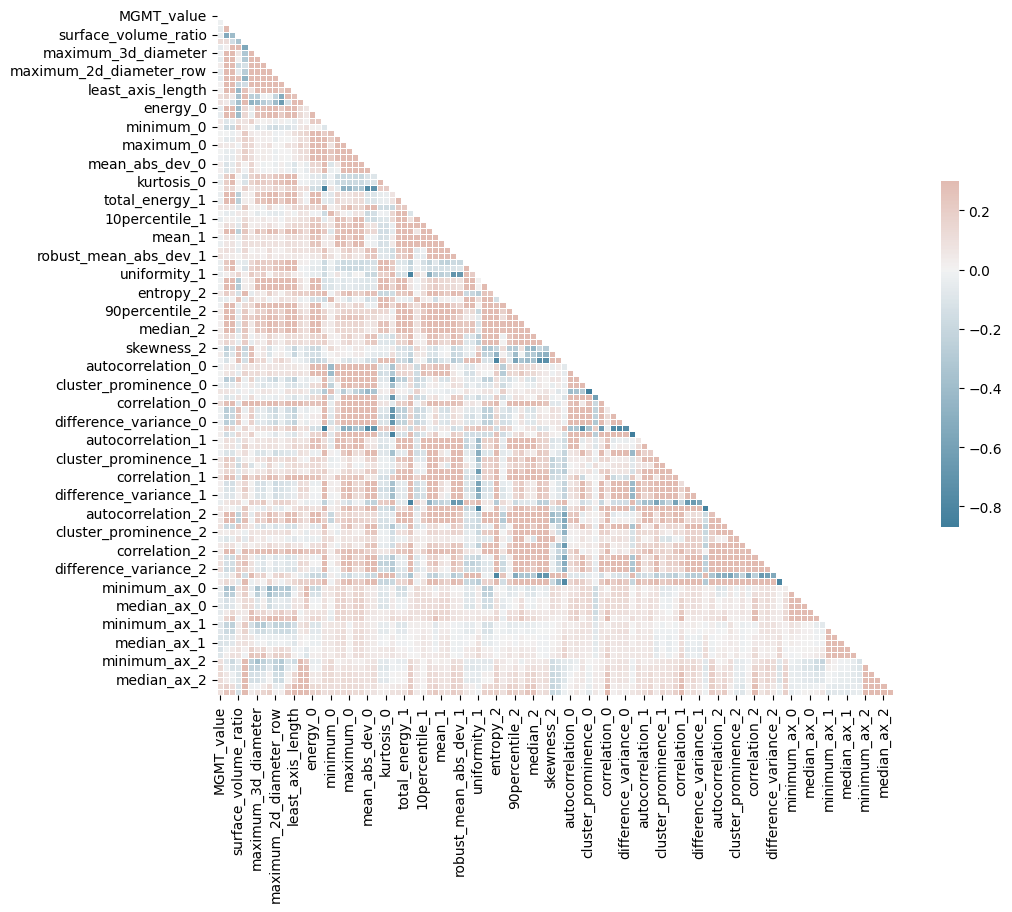

In [7]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.close('all')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [8]:
mgmt_corr_sorted = corr['MGMT_value'].sort_values()
mgmt_corr_sorted[:5], mgmt_corr_sorted[-6:-1]

(percentile90_ax_1   -0.115617
 median_ax_1         -0.107567
 mean_ax_1           -0.103234
 maximum_ax_1        -0.090067
 percentile10_ax_1   -0.082246
 Name: MGMT_value, dtype: float64,
 correlation_0        0.119817
 median_ax_2          0.126024
 percentile10_ax_2    0.126604
 percentile90_ax_2    0.127253
 mean_ax_2            0.128695
 Name: MGMT_value, dtype: float64)

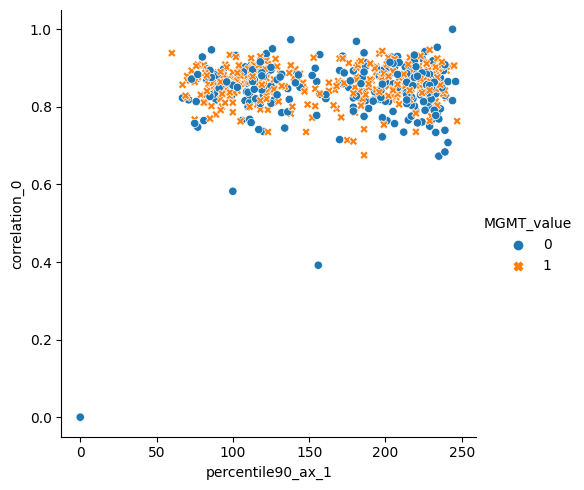

In [9]:
sns.relplot(x='percentile90_ax_1', y="correlation_0", hue="MGMT_value", style="MGMT_value", data=df_all)
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

def get_data(fold, features):
    df = df_all.dropna(inplace=False)
    scaler = StandardScaler()
    
    df_train = df[df.fold != fold]
    df_val = df[df.fold == fold]
    if len(df_val) == 0:
        df_val = df[df.fold == 0]
    
    # shuffle train
    df_train = df_train.sample(frac=1)
    
    y_train = df_train.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    y_val = df_val.MGMT_value.to_numpy().reshape((-1,1)).astype(np.float32)
    
    X_train = df_train[features].to_numpy().astype(np.float32)
    X_val = df_val[features].to_numpy().astype(np.float32)
    
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    return X_train, y_train, X_val, y_val, scaler, (df_train.index.values).flatten(), (df_val.index.values).flatten()

def measure_cv_score(parameters, verbose=False, train_one_model=False, plot=False, return_oof_preds=False):
    
    val_preds = []
    val_gts = []
    val_aucs = []
    val_accs = []
    val_index_values = []
    
    for fold in range(5):
        
        if train_one_model: fold = -1
        
        X_train, y_train, X_val, y_val, scaler, train_index, val_index = get_data(fold, features=parameters['features'])
        val_index_values = val_index_values + list(val_index)
        
        if parameters['model_type'] == 'xgb':
            model = xgb.XGBRegressor(
                    n_estimators=parameters['n_estimators'], 
                    max_depth=parameters['max_depth'], 
                    eta=parameters['eta'],
                    subsample=parameters['subsample'], 
                    colsample_bytree=parameters['colsample_bytree'],
                    gamma=parameters['gamma']
                )
        elif parameters['model_type'] == 'linreg':
            model = linear_model.LinearRegression()
        elif parameters['model_type'] == 'ridge':
            model = linear_model.Ridge(parameters['alpha'])
        elif parameters['model_type'] == 'bayesian':
            model = linear_model.BayesianRidge(
                n_iter = parameters['n_iter'],
                lambda_1 = parameters['lambda_1'],
                lambda_2 = parameters['lambda_2'],
                alpha_1 = parameters['alpha_1'],
                alpha_2 = parameters['alpha_2'],
            )
        elif parameters['model_type'] == 'logreg':
            model = linear_model.LogisticRegression()
        elif parameters['model_type'] == 'lassolarsic':
            model = linear_model.LassoLarsIC(
                max_iter = parameters['max_iter'],
                eps = parameters['eps']
            )
        elif parameters['model_type'] == 'perceptron':
            model = linear_model.Perceptron(
            )
        else:
            raise NotImplementedError
        
        model.fit(X_train, y_train.ravel())
        
        if train_one_model:
            return model, scaler
        
        val_pred = model.predict(X_val)
        val_preds += list(val_pred)
        val_gts += list(y_val)
        val_aucs.append(roc_auc_score(np.array(y_val).flatten().astype(np.float32), np.array(val_pred).flatten()))
        val_accs.append(accuracy_score((np.array(y_val) > 0.5).flatten(), (np.array(val_pred) > 0.5).flatten()))
    
    if return_oof_preds:
        return np.array(val_preds).flatten(), np.array(val_gts).flatten(), val_index_values
    
    oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
    oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
    auc_std = np.std(np.array(val_aucs))
    
    if plot:
        df_plot = pd.DataFrame({'Pred-MGMT': np.array(val_preds).flatten(), 'GT-MGMT': np.array(val_gts).flatten()})
        sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
        plt.title(f'{parameters["model_type"]} # CV AUC = {oof_auc:.3f} (std {auc_std:.3f}), Acc. = {oof_acc:.3f}')
        plt.show()
    
    if verbose:
        print(f'CV AUC = {oof_auc} (std {auc_std}), Acc. = {oof_acc}, aucs: {val_aucs}, accs: {val_accs}')
    
    # optimize lower limit of the (2x std range around mean)
    # This way, we choose the model which ranks well and performs ~equally well on all folds
    return float(oof_auc) - auc_std

In [11]:
default_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 1000,
    'max_depth' : 3,
    'eta': 0.12,
    'subsample': 0.7,
    'colsample_bytree' : 0.8,
    'gamma' : 1.0,
    'alpha' : 1.0,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : all_feat_names
}
measure_cv_score(default_parameters, verbose=True)

CV AUC = 0.557477490490635 (std 0.03000806849555598), Acc. = 0.5355285961871751, aucs: [0.5167155425219941, 0.5460410557184752, 0.6083535108958839, 0.5654545454545454, 0.5498432601880877], accs: [0.5299145299145299, 0.5641025641025641, 0.5739130434782609, 0.5217391304347826, 0.48672566371681414]


/home/joni/miniconda3/envs/brainclf/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:598: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 32 iterations, alpha=3.672e-04, previous alpha=3.669e-04, with an active set of 29 regressors.
  warnings.warn('Early stopping the lars path, as the residues '


0.5274694219950791

In [12]:
def feat_selection_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = default_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 0:
    study = optuna.create_study()
    study.optimize(feat_selection_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

In [13]:
if 0:
    for name, sel in study.best_params.items():
        if sel == 1:
            print(f'"{name}",')

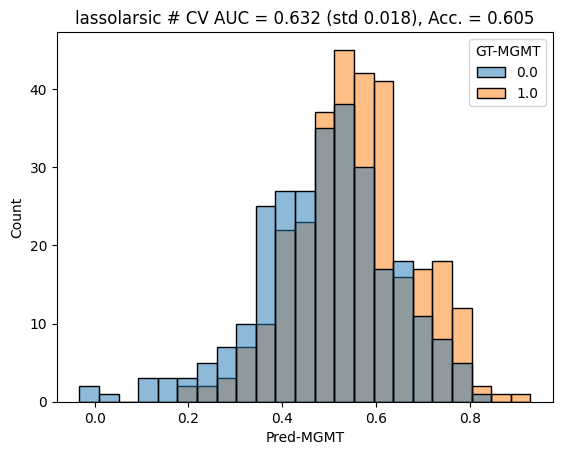

CV AUC = 0.6317709085656507 (std 0.01818126789005147), Acc. = 0.6048526863084922, aucs: [0.6017595307917889, 0.6568914956011731, 0.6301452784503632, 0.6393939393939394, 0.6407523510971787], accs: [0.5897435897435898, 0.6239316239316239, 0.5826086956521739, 0.6086956521739131, 0.6194690265486725]


0.6135896406755992

In [14]:
selected_features = [
    "mesh_volume",
    "sphericity",
    "maximum_2d_diameter_column",
    "maximum_2d_diameter_row",
    "elongation",
    "energy_0",
    "median_0",
    "robust_mean_abs_dev_0",
    "uniformity_0",
    "total_energy_1",
    "maximum_1",
    "median_1",
    "robust_mean_abs_dev_1",
    "uniformity_1",
    "median_2",
    "skewness_2",
    "kurtosis_2",
    "uniformity_2",
    "cluster_shade_0",
    "cluster_tendency_0",
    "correlation_0",
    "difference_entropy_0",
    "difference_variance_0",
    "joint_entropy_0",
    "autocorrelation_1",
    "joint_avg_1",
    "contrast_1",
    "cluster_prominence_1",
    "cluster_tendency_1",
    "difference_variance_1",
    "joint_avg_2",
    "cluster_tendency_2",
    "correlation_2",
    "difference_average_2",
    "difference_entropy_2",
    "difference_variance_2",
    "joint_energy_2",
    "joint_entropy_2",
    "minimum_ax_0",
    "percentile10_ax_0",
    "mean_ax_0",
    "median_ax_0",
    "percentile90_ax_0",
    "maximum_ax_0",
    "minimum_ax_1",
    "percentile10_ax_1",
    "mean_ax_1",
    "median_ax_1",
    "minimum_ax_2",
    "median_ax_2",
]

feature_pruned_parameters = {
    'model_type': 'lassolarsic',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
tuned_lassolarsic_parameters = feature_pruned_parameters.copy()
measure_cv_score(tuned_lassolarsic_parameters, verbose=True, plot=True)

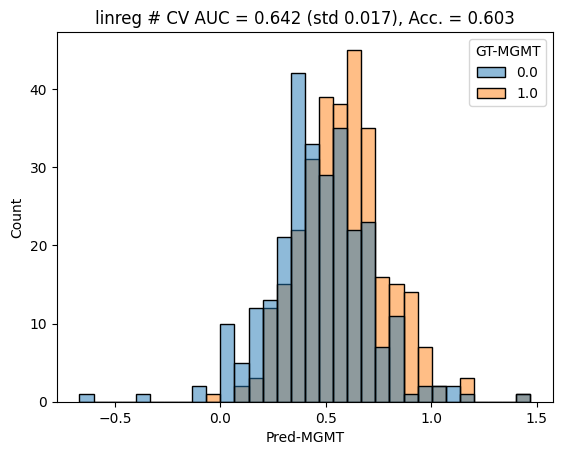

CV AUC = 0.6417015744619385 (std 0.01703785674394787), Acc. = 0.6031195840554593, aucs: [0.6173020527859238, 0.670674486803519, 0.6425544794188862, 0.6475757575757576, 0.6404388714733542], accs: [0.5726495726495726, 0.6410256410256411, 0.6, 0.5826086956521739, 0.6194690265486725]


0.6246637177179907

In [15]:
tuned_linreg_parameters = {
    'model_type': 'linreg',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
measure_cv_score(tuned_linreg_parameters, verbose=True, plot=True)

In [16]:
def feat_selection_linreg_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = tuned_linreg_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 0:
    study = optuna.create_study()
    study.optimize(feat_selection_linreg_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

In [17]:
if 0:
    for name, sel in study.best_params.items():
        if sel == 1:
            print(f'"{name}",')

In [44]:
selected_linreg_features = [
    "spherical_disproportion",
    "maximum_3d_diameter",
    "least_axis_length",
    "flatness",
    "90percentile_0",
    "kurtosis_0",
    "uniformity_0",
    "total_energy_1",
    "10percentile_1",
    "mean_1",
    "median_1",
    "robust_mean_abs_dev_1",
    "skewness_1",
    "maximum_2",
    "mean_2",
    "skewness_2",
    "kurtosis_2",
    "uniformity_2",
    "autocorrelation_0",
    "joint_avg_0",
    "cluster_tendency_0",
    "difference_average_0",
    "difference_variance_0",
    "joint_energy_0",
    "autocorrelation_1",
    "contrast_1",
    "cluster_prominence_1",
    "cluster_tendency_1",
    "difference_average_1",
    "autocorrelation_2",
    "joint_avg_2",
    "cluster_prominence_2",
    "cluster_tendency_2",
    "difference_average_2",
    "joint_energy_2",
    "minimum_ax_0",
    "mean_ax_0",
    "maximum_ax_0",
    "minimum_ax_1",
    "percentile10_ax_1",
    "percentile90_ax_1",
    "maximum_ax_1",
    "median_ax_2",
]

final_linreg_parameters = tuned_linreg_parameters.copy()
final_linreg_parameters['features'] = selected_linreg_features

measure_cv_score(final_linreg_parameters, verbose=True, plot=False)

CV AUC = 0.6479368289277287 (std 0.0036872525009322117), Acc. = 0.6377816291161178, aucs: [0.6457478005865103, 0.6448680351906159, 0.6540556900726393, 0.6436363636363637, 0.6460815047021944], accs: [0.6410256410256411, 0.6581196581196581, 0.6260869565217392, 0.6347826086956522, 0.6283185840707964]


0.6442495764267966

In [19]:
tuned_ridge_parameters = {
    'model_type': 'ridge',
    'n_estimators': 245,
    'max_depth' : 4,
    'eta': 0.12309061558731829,
    'subsample': 0.9927722396906344,
    'colsample_bytree' : 0.6198696510524733,
    'gamma' : 1.8267387708396023,
    'alpha' : 2.50433689492789,
    'n_iter':300,
    'lambda_1': 1e-6, # bayesian
    'lambda_2':1e-6, # bayesian
    'alpha_1': 1e-6, # bayesian
    'alpha_2': 1e-6, # bayesian
    'max_iter': 50, #lasso
    'eps': 1e-6, #lasso
    'features' : selected_features
}
measure_cv_score(tuned_ridge_parameters, verbose=True, plot=False)

CV AUC = 0.6402330396263661 (std 0.02073345267037972), Acc. = 0.6065857885615251, aucs: [0.6120234604105571, 0.6718475073313783, 0.6283292978208233, 0.6551515151515152, 0.6413793103448276], accs: [0.5897435897435898, 0.6410256410256411, 0.6347826086956522, 0.5652173913043478, 0.6017699115044248]


0.6194995869559864

In [20]:
def feat_selection_ridge_objective(trial):
    kept_feats = []
    for i in range(len(all_feat_names)):
        var = trial.suggest_int(all_feat_names[i], 0,1)
        if var == 1:
            kept_feats.append(all_feat_names[i])
    parameters = tuned_ridge_parameters.copy()
    parameters['features'] = kept_feats
    
    return 1 - measure_cv_score(parameters, verbose=False)

if 0:
    study = optuna.create_study()
    study.optimize(feat_selection_ridge_objective, n_trials=1000, show_progress_bar=True)
    print(study.best_value, study.best_params)

In [21]:
if 0:
    for name, sel in study.best_params.items():
        if sel == 1:
            print(f'"{name}",')

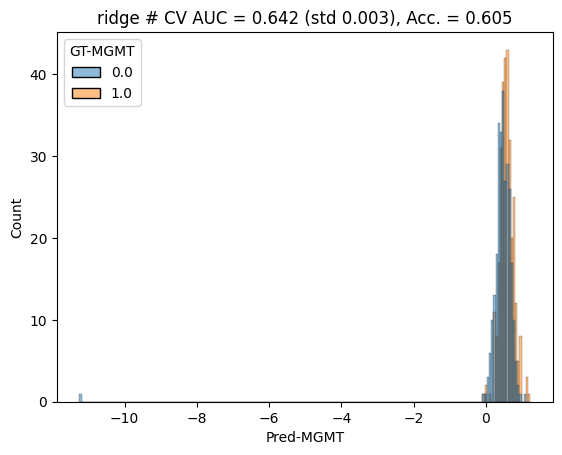

CV AUC = 0.6422432471471905 (std 0.002512536343297572), Acc. = 0.6048526863084922, aucs: [0.6419354838709677, 0.6460410557184751, 0.6398305084745763, 0.6436363636363637, 0.6391849529780564], accs: [0.5811965811965812, 0.6495726495726496, 0.6173913043478261, 0.5826086956521739, 0.5929203539823009]


0.6397307108038929

In [42]:
selected_ridge_features = [
    "mesh_volume",
    "surface_volume_ratio",
    "maximum_3d_diameter",
    "maximum_2d_diameter_column",
    "maximum_2d_diameter_row",
    "minor_axis_length",
    "elongation",
    "energy_0",
    "entropy_0",
    "minimum_0",
    "mean_abs_dev_0",
    "skewness_0",
    "uniformity_0",
    "energy_1",
    "total_energy_1",
    "maximum_1",
    "mean_1",
    "median_1",
    "robust_mean_abs_dev_1",
    "kurtosis_1",
    "energy_2",
    "total_energy_2",
    "entropy_2",
    "minimum_2",
    "10percentile_2",
    "90percentile_2",
    "maximum_2",
    "mean_abs_dev_2",
    "robust_mean_abs_dev_2",
    "kurtosis_2",
    "contrast_0",
    "correlation_0",
    "difference_average_0",
    "joint_entropy_0",
    "autocorrelation_1",
    "joint_avg_1",
    "cluster_prominence_1",
    "cluster_tendency_1",
    "difference_average_1",
    "difference_variance_1",
    "joint_energy_1",
    "joint_entropy_1",
    "cluster_tendency_2",
    "correlation_2",
    "difference_entropy_2",
    "difference_variance_2",
    "maximum_ax_0",
    "mean_ax_1",
    "median_ax_2",
]

final_ridge_parameters = tuned_ridge_parameters.copy()
final_ridge_parameters['features'] = selected_ridge_features

measure_cv_score(final_ridge_parameters, verbose=True, plot=True)

Models that perform well are LassoLarsIC, LinearRegression and RidgeRegression

## Ensemble of three models

In [103]:
def normalize_pred_distribution(preds, min_percentile=10, max_percentile=90):
    """ Clips min and max percentiles and Z-score normalizes """
    min_range = np.percentile(preds, min_percentile)
    max_range = np.percentile(preds, max_percentile)
    norm_preds = np.clip(preds, min_range, max_range)
    pred_std = np.std(norm_preds)
    pred_mean = np.mean(norm_preds)
    norm_preds = (norm_preds - pred_mean) / (pred_std + 1e-6)
    return norm_preds

def rescale_pred_distribution(preds):
    """ Rescales pred distribution to 0-1 range. Doesn't affect AUC """
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds) + 1e-6)

acc 0.6031195840554593, auc 0.6529804034859646


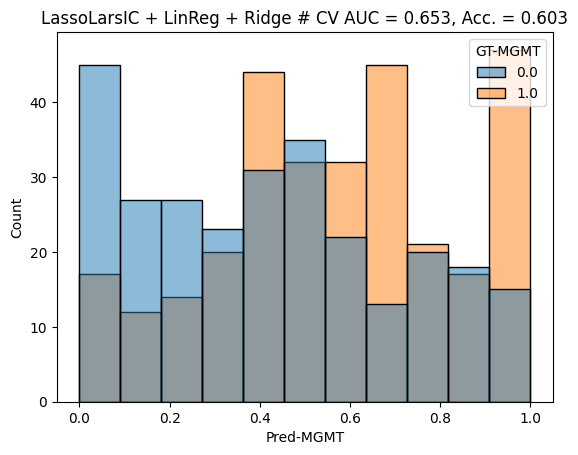

In [104]:
val_preds, val_gts = [], []
for params in [tuned_lassolarsic_parameters, final_linreg_parameters, final_ridge_parameters]:
    val_pred, val_gt, _ = measure_cv_score(params, return_oof_preds=True)
    val_preds.append(normalize_pred_distribution(val_pred))
    val_gts.append(val_gt)
val_preds = rescale_pred_distribution(np.mean(np.stack(val_preds), axis=0))
val_gts = np.mean(np.stack(val_gts), axis=0)

oof_acc = accuracy_score((np.array(val_gts) > 0.5).flatten(), (np.array(val_preds) > 0.5).flatten())
oof_auc = roc_auc_score(np.array(val_gts).flatten().astype(np.float32), np.array(val_preds).flatten())
print(f'acc {oof_acc}, auc {oof_auc}')

plt.close('all')
df_plot = pd.DataFrame({'Pred-MGMT': val_preds, 'GT-MGMT': val_gts})
sns.histplot(x='Pred-MGMT', hue='GT-MGMT', data=df_plot)
plt.title(f'LassoLarsIC + LinReg + Ridge # CV AUC = {oof_auc:.3f}, Acc. = {oof_acc:.3f}')
plt.show()

In [41]:
from joblib import dump, load
import json

save_dir = '../output/20210925_segmentation_feature_model_v3'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for i, params in enumerate([tuned_lassolarsic_parameters, final_linreg_parameters, final_ridge_parameters]):
    model, scaler = measure_cv_score(params, train_one_model=True)
    model_fn = os.path.join(save_dir, f'feature_model_{i}.joblib')
    dump(model, model_fn)
    
    #save oof preds
    oof_preds, oof_gts, oof_index_values = measure_cv_score(params, return_oof_preds=True)
    df_oof = df_all.copy()
    df_oof['oof_pred'] = 0.5
    df_oof = df_oof[['BraTS21ID','MGMT_value','fold','oof_pred']]
    df_oof.loc[np.array(oof_index_values), 'oof_pred'] = oof_preds
    df_oof.to_csv(os.path.join(save_dir, f'feature_model_oofs_{i}.csv'), index=False)

    scaler_fn = os.path.join(save_dir, f'feature_model_scaler_{i}.joblib')
    dump(scaler, scaler_fn)

    param_fn = os.path.join(save_dir, f'params_{i}.json')
    with open(param_fn, 'w', encoding='utf-8') as f:
        json.dump(params, f, indent=4)